In [1]:
from tensorflow.data import AUTOTUNE
import tensorflow_datasets as tfds

from models.auramask import AuraMask
from losses.reface import ReFaceLoss, FaceEmbedEnum

from keras_cv.layers import Resizing, Rescaling, Augmenter
from keras.optimizers import Adam

BATCH_SIZE = 16

2024-02-14 19:41:55.369470: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-14 19:41:55.406456: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 19:41:55.406478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 19:41:55.407350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 19:41:55.413579: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow backend


# Algorithm 1: Ensemble attack training procedure
Inputs:
- Victim Models (F)
- Image Dataset (X)

Outputs:
- Perturbation Engine (g_theta)

HyperParams:
- Learning rate (alpha)
- L_inf bound (epsilon)
- Lpips loss coefficient (lambda)

## Inputs

### Victim Models (F)

In [2]:
F = [
  FaceEmbedEnum.ARCFACE
]

### Image Dataset (X)

In [3]:
ds, info = tfds.load('lfw',
                     decoders=tfds.decode.PartialDecoding({
                       'image': True,
                     }),
                     with_info=True,
                     download=True,
                     as_supervised=False)

2024-02-14 19:41:58.559470: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-14 19:41:58.596815: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-14 19:41:58.598255: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
train_ds = ds['train']

In [5]:
augmenter = Augmenter(
  [
    Rescaling(1./255),
    Resizing(128,128),
  ]
)

def preprocess_data(images, augment=True):
  inputs = {"images": images}
  outputs = augmenter(inputs)
  return outputs['images'], outputs['images']

In [6]:
train_ds = train_ds.batch(BATCH_SIZE).map(
  lambda x: preprocess_data(x['image']),
  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

2024-02-14 19:42:00.510343: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


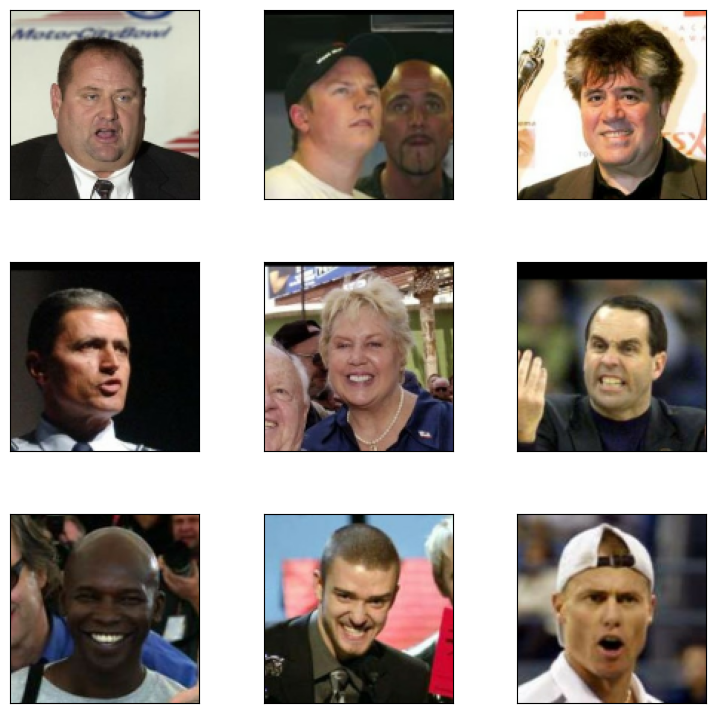

In [7]:
fig = tfds.show_examples(train_ds, info, is_batched=True)

## HyperParams

In [8]:
alpha = 0.2
epsilon = 0.5
l = 0.2

### Initialized ATN ($N_{theta}$)

In [9]:
model = AuraMask(n_filters=32, n_dims=3, eps=epsilon)

In [10]:
model.compile(optimizer=Adam(learning_rate=alpha), loss=ReFaceLoss(F=F, l=l), metrics=[])

In [11]:
for batch in train_ds.take(1):
  altered = model(batch[0])

2024-02-14 19:42:02.661040: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-14 19:42:02.700355: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-14 19:42:02.759883: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-14 19:42:03.048127: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [12]:
import matplotlib.pyplot as plt

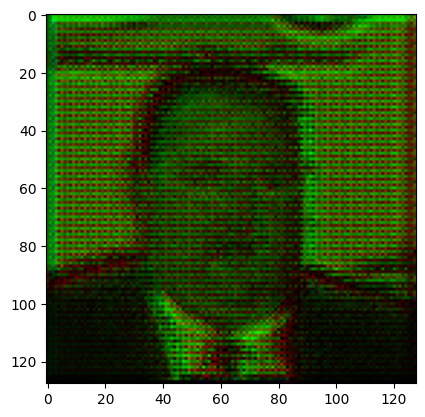

In [13]:
plt.imshow(altered[0,...])
plt.show()

In [14]:
model.fit(train_ds)

AttributeError: in user code:

    File "/opt/miniconda/envs/unet/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/coder/face-benchmark/losses/reface.py", line 42, in call  *
        LpipsLoss = self.lpips_loss(y_true, y_pred)
    File "/home/coder/face-benchmark/losses/reface.py", line 101, in lpips_loss  *
        loss = tf.multiply(
    File "/opt/miniconda/envs/unet/lib/python3.11/site-packages/lpips_tf.py", line 60, in lpips  *
        default_graph = tf.get_default_graph()

    AttributeError: module 'tensorflow' has no attribute 'get_default_graph'


## Train Loop

In [ ]:
def train(X, F, model, optimizer, eps, lda):
  for epoch in range(epoch):
    print("\nEpoch: %d" % (epoch,))
    for step, (x_batch) in enumerate(X):
      # Open GradientTape to record ops run during forward pass for auto-differentiation
      with tf.GradientTape() as tape:
        # Forward pass of layer.
        # Ops applied recorded on GradientTape
        x_adv = addAdversarialNoise(x_batch, eps, model, True)
        loss = atnLoss(x_batch, x_adv, F, lda)
      
      # Use gradient tape to retrieve grads of trainable variables wrt loss
      grads = tape.gradient(loss, model.trainable_weights)
      
      # Gradient descent, update variables to minimize loss.
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
      
      if step % 200 == 0:
        print(
          "Training loss (for one batch) at step %d: %.4f"
          % (step, float(loss))
        )

: 